<h1><center>Clustering</center></h1>

In [2]:
#import packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

### Reading the data

In [3]:
#Read the first file
df1 = pd.read_csv('data_median.csv')
df1

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
0,2L52.1,ADE,29.40,29.40,29.4,29.4,29.4,29.4,29.40,29.40,0
1,2L52.1,ADEsh,19.60,19.60,19.6,19.6,19.6,19.6,19.60,19.60,0
2,2L52.1,ADL,1.15,1.15,19.7,2.3,2.3,2.3,1.15,1.15,0
3,2L52.1,ASE,1.20,1.20,1.2,1.2,1.2,1.2,1.20,1.20,0
4,2L52.1,ASH,12.10,12.10,12.1,12.1,12.1,12.1,12.10,12.10,0
...,...,...,...,...,...,...,...,...,...,...,...
854318,zyx-1,mu_sph,23.60,23.60,23.6,23.6,23.6,23.6,23.60,23.60,0
854319,zyx-1,pm3_pm4_pm5,1.35,1.35,3.4,4.4,4.6,2.7,1.35,1.35,0
854320,zyx-1,pm6,6.50,6.50,6.5,6.5,6.5,6.5,6.50,6.50,0
854321,zyx-1,pm7,0.90,0.90,0.9,0.9,0.9,0.9,0.90,0.90,0


The first issue I see with the data, even though we use a median data, is the recurrence of the values for the different time bins. Indeed, I believe this is how the data has been pre-processed, and it therefore makes it difficult to make a real case-study related to the different time bins, as they will in majority all have the same values throughout the different time intervals.

We will therefore work on our clustering without taking into account these features at first.
At the end we will take into consideration these time bins given a hypothesis we will make.

In [4]:
#Read the second file for cell_types
df2 = pd.read_csv('annotation.csv')
df2

,cell_type,cell_status,centriole
0,ADE,non_proliferating,absent
1,ADEsh,non_proliferating,absent
2,ADF,non_proliferating,absent
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating,absent
4,ADL,non_proliferating,absent
...,...,...,...
137,URB_and_possibly_URA,non_proliferating,absent
138,URX,non_proliferating,absent
139,XXX,non_proliferating,absent
140,Y,non_proliferating,present


### Playing a little bit with the data

In [5]:
#Some centrioles have value 'ambiguous'
df1['centriole'].unique()

array(['0', 'ambiguous', '1'], dtype=object)

In [6]:
df1['centriole'].value_counts(normalize=True)

0            0.843766
1            0.134298
ambiguous    0.021935
Name: centriole, dtype: float64

In [7]:
df2['centriole'].unique()

array(['absent', 'present', 'ambiguous'], dtype=object)

In [8]:
#Get rid of the ambiguous values
ambig = ['ambiguous']
df1 = df1[~df1['centriole'].isin(ambig)]
df2 = df2[~df2['centriole'].isin(ambig)]

In [9]:
df1 #Now 835583 rows

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
0,2L52.1,ADE,29.40,29.40,29.4,29.4,29.4,29.4,29.40,29.40,0
1,2L52.1,ADEsh,19.60,19.60,19.6,19.6,19.6,19.6,19.60,19.60,0
2,2L52.1,ADL,1.15,1.15,19.7,2.3,2.3,2.3,1.15,1.15,0
3,2L52.1,ASE,1.20,1.20,1.2,1.2,1.2,1.2,1.20,1.20,0
4,2L52.1,ASH,12.10,12.10,12.1,12.1,12.1,12.1,12.10,12.10,0
...,...,...,...,...,...,...,...,...,...,...,...
854318,zyx-1,mu_sph,23.60,23.60,23.6,23.6,23.6,23.6,23.60,23.60,0
854319,zyx-1,pm3_pm4_pm5,1.35,1.35,3.4,4.4,4.6,2.7,1.35,1.35,0
854320,zyx-1,pm6,6.50,6.50,6.5,6.5,6.5,6.5,6.50,6.50,0
854321,zyx-1,pm7,0.90,0.90,0.9,0.9,0.9,0.9,0.90,0.90,0


In [10]:
#Just getting an idea of how many have centriole=1
df1.loc[df1['centriole'].astype(float) == 1]

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole
22,2L52.1,Germline,0.40,0.4,0.4,0.4,0.40,0.40,0.40,0.40,1
24,2L52.1,Intestine,2.10,3.8,8.9,1.7,0.85,0.85,0.85,0.85,1
25,2L52.1,Intestine_middle_and_posterior,1.50,1.5,1.5,1.5,1.50,1.50,1.50,1.50,1
26,2L52.1,P_cell,1.50,1.5,1.5,1.5,1.50,1.50,1.50,1.50,1
31,2L52.1,Seam_cell,0.25,2.9,5.7,1.1,0.25,0.50,0.25,0.25,1
...,...,...,...,...,...,...,...,...,...,...,...
854290,zyx-1,Intestine_middle_and_posterior,0.00,0.0,0.0,0.0,0.70,0.00,0.00,1.10,1
854291,zyx-1,M_cell,0.00,0.0,6.5,0.1,0.00,0.00,0.00,27.30,1
854296,zyx-1,P_cell,0.00,1.1,0.0,14.6,0.00,0.00,0.00,0.00,1
854306,zyx-1,Seam_cell,0.00,0.0,0.0,4.1,28.30,17.40,0.00,0.00,1


In [11]:
df2 #Now 139 rows

,cell_type,cell_status,centriole
0,ADE,non_proliferating,absent
1,ADEsh,non_proliferating,absent
2,ADF,non_proliferating,absent
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating,absent
4,ADL,non_proliferating,absent
...,...,...,...
137,URB_and_possibly_URA,non_proliferating,absent
138,URX,non_proliferating,absent
139,XXX,non_proliferating,absent
140,Y,non_proliferating,present


In [12]:
df1['gene'].value_counts()

tads-1        137
nuo-3         137
nduo-5        137
nduo-6        137
C02F5.12      137
             ... 
Y37E11AL.1      1
Y37E11AL.9      1
Y8A9A.2         1
F02D10.3        1
Y4C6B.4         1
Name: gene, Length: 17134, dtype: int64

In [13]:
df1['cell_type'].value_counts()

BWM_anterior         12066
BWM_posterior        12031
BWM_head_row_1       10988
Seam_cell            10958
Intestine            10918
                     ...  
AIZ                   2307
Excretory_pore_G1     2031
PVR                   1617
XXX                   1616
FLP                   1372
Name: cell_type, Length: 137, dtype: int64

In [14]:
#Remove the 'centriole' column from df2 as it has alraedy been processed for df1
keep_col = ['cell_type', 'cell_status']
df2 = df2[keep_col]
df2

,cell_type,cell_status
0,ADE,non_proliferating
1,ADEsh,non_proliferating
2,ADF,non_proliferating
3,ADF_AWB_terminal_cells_but_undifferentiated,non_proliferating
4,ADL,non_proliferating
...,...,...
137,URB_and_possibly_URA,non_proliferating
138,URX,non_proliferating
139,XXX,non_proliferating
140,Y,non_proliferating


In [15]:
#Relational algebra
data_use = pd.merge(df1, df2, on="cell_type")
data_use

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole,cell_status
0,2L52.1,ADE,29.4,29.4,29.4,29.4,29.4,29.4,29.4,29.4,0,non_proliferating
1,2RSSE.1,ADE,105.2,105.2,105.2,105.2,105.2,105.2,105.2,105.2,0,non_proliferating
2,AH9.3,ADE,37.8,37.8,37.8,37.8,37.8,37.8,37.8,37.8,0,non_proliferating
3,B0025.4,ADE,89.5,89.5,89.5,89.5,89.5,89.5,89.5,89.5,0,non_proliferating
4,B0035.1,ADE,133.5,133.5,133.5,133.5,133.5,133.5,133.5,133.5,0,non_proliferating
...,...,...,...,...,...,...,...,...,...,...,...,...
835578,ztf-7,Possibly_ant_arc_V,36.7,36.7,36.7,36.7,36.7,36.7,36.7,36.7,0,non_proliferating
835579,ztf-9,Possibly_ant_arc_V,8.6,8.6,8.6,8.6,8.6,8.6,8.6,8.6,0,non_proliferating
835580,zyg-11,Possibly_ant_arc_V,9.5,9.5,9.5,9.5,9.5,9.5,9.5,9.5,0,non_proliferating
835581,zyg-12,Possibly_ant_arc_V,122.9,122.9,122.9,122.9,122.9,122.9,122.9,122.9,0,non_proliferating


For the moment, we will mainly focus on the cell_type for the clustering; and the information on the cell status, on whether there was a proliferation or not.

### Idea:

After making a few arrangements to data types, we will cluster the cell_types in 2 clusters, basically 0 for absence of centriole and 1 for presence of centriole.
In order to do that, as you will see in the code, I will actually count how many times each cell_type appears (on centriole=0 or centriole=1) and work on my clusters from there.

In [16]:
col = ['gene','cell_type','centriole','cell_status']
print(data_use[col].dtypes)

gene           object
cell_type      object
centriole      object
cell_status    object
dtype: object


First, we see that many features have type object, let's make it a float / string, in order to be able to play with it.

In [17]:
data_use['centriole'] = data_use['centriole'].astype(float)
print(data_use[col].dtypes)

gene            object
cell_type       object
centriole      float64
cell_status     object
dtype: object


In [18]:
data_use['cell_type'] = data_use['cell_type'].astype('string')
data_use['cell_status'] = data_use['cell_status'].astype('string')
print(data_use[col].dtypes)

gene            object
cell_type       string
centriole      float64
cell_status     string
dtype: object


In [19]:
data_use['centriole'].value_counts()

0.0    720849
1.0    114734
Name: centriole, dtype: int64

In [20]:
data_use[['cell_type', 'centriole']].value_counts()

cell_type          centriole
BWM_anterior       0.0          12066
BWM_posterior      0.0          12031
BWM_head_row_1     0.0          10988
Seam_cell          1.0          10958
Intestine          1.0          10918
                                ...  
AIZ                0.0           2307
Excretory_pore_G1  1.0           2031
PVR                0.0           1617
XXX                0.0           1616
FLP                0.0           1372
Length: 137, dtype: int64

In [22]:
# Doing the count for each cell_type 
# the value for centriole doesn't change anyways for each cell_type, 
# i.e. can't find 'ADE' with centriole=0 and 'ADE' with centriole=1
first_idea_cols = ['cell_type', 'centriole']
dg = data_use[first_idea_cols]
dg.groupby(first_idea_cols)[first_idea_cols].count()
dg = dg.groupby(first_idea_cols).size().reset_index(name='count')
dg

,cell_type,centriole,count
0,ADE,0.0,4439
1,ADEsh,0.0,2741
2,ADF,0.0,5968
3,ADL,0.0,8916
4,AFD,0.0,7605
...,...,...,...
132,pm1_pm2,0.0,6954
133,pm3_pm4_pm5,0.0,10422
134,pm6,0.0,6542
135,pm7,0.0,7202


Text(0, 0.5, 'Number of cell types')

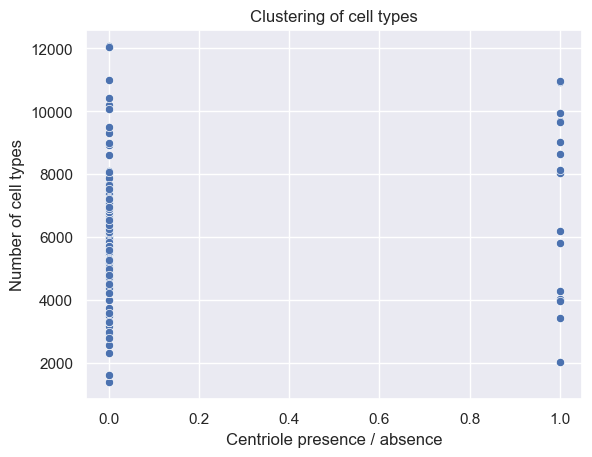

In [31]:
# K-means algorithm (k=2 for 2 clusters)
kmeans = KMeans(2)
keep = ['centriole', 'count']
d = dg[keep]
kmeans.fit(d.astype(float))
identified_clusters = kmeans.fit_predict(d)
data_with_clusters = d.copy()
data_with_clusters['Clusters'] = identified_clusters 


sns.scatterplot(x=data_with_clusters['centriole'],
               y=data_with_clusters['count'])
plt.title('Clustering of cell types')
# Set x-axis label
plt.xlabel('Centriole presence / absence')
# Set y-axis label
plt.ylabel('Number of cell types')

In [33]:
#Take cell_types for which centriole=1
list_of_cell_types_centriole = []
for cell in dg.values:
    if(cell[1]==1):
        list_of_cell_types_centriole.append(cell[0])
list_of_cell_types_centriole

['AMso',
 'B',
 'Excretory_pore_G1',
 'F_U',
 'G2_and_W_blasts',
 'Germline',
 'Intestine',
 'Intestine_anterior',
 'Intestine_far_posterior',
 'Intestine_middle_and_posterior',
 'M_cell',
 'P_cell',
 'Seam_cell',
 'T',
 'Y',
 'Z1_Z4']

Then, from the list of cell types that I found in my clustering, I take those which are important for the apparition of centriole.
Going back to my dataframe, I only select the rows related to these cell types.
I add another detail which is that I ignore all cell types for which there was no cell development throughout time (described by a 0 value in the time bins)

In [34]:
g=data_use
g = g.loc[g['cell_type'].isin(list_of_cell_types_centriole)]
# I will keep only the cell types for which there was a proliferation, 
# the status was given in the annotations file in the beginning, from the paper
g=g.loc[g['cell_status']=='proliferating']
g=g.loc[(g['210_270']!=0)&(g['270_330']!=0)&(g['330_390']!=0)&(g['390_450']!=0)&(g['450_510']!=0)&(g['510_580']!=0)&(g['580_650']!=0)&(g['gt_650']!=0)]
g

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole,cell_status
165239,2L52.1,Germline,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,1.0,proliferating
165240,AH10.2,Germline,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,1.0,proliferating
165253,B0025.5,Germline,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.0,proliferating
165254,B0034.5,Germline,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,1.0,proliferating
165258,B0035.21,Germline,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,1.0,proliferating
...,...,...,...,...,...,...,...,...,...,...,...,...
833008,ztf-9,G2_and_W_blasts,34.1,34.1,34.1,34.1,34.1,34.1,34.1,34.1,1.0,proliferating
833009,zyg-1,G2_and_W_blasts,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,1.0,proliferating
833010,zyg-11,G2_and_W_blasts,50.1,50.1,50.1,50.1,50.1,50.1,50.1,50.1,1.0,proliferating
833011,zyg-12,G2_and_W_blasts,36.8,36.8,36.8,36.8,36.8,36.8,36.8,36.8,1.0,proliferating


When trying to think about how I could eventually use my time bins data. 
I know that the cell will split into two different cells every time (i.e. embryogenesis) as explained by the professor. Therefore, in order to keep a relevant data for the time bins, I only consider the cells for which, at some point, there has been a cell division and growth. I evaluate that by looking at my time bins and keeping those for which at some point we had more cells than in the past. For example, the number of cells from [270_330] is bigger than it was in [210_270]...

In [35]:
f=g.loc[(g['210_270']>g['270_330'])|(g['270_330']>g['330_390'])|(g['330_390']>g['390_450'])|(g['390_450']>g['450_510'])|(g['450_510']>g['510_580'])|(g['510_580']>g['580_650'])|(g['580_650']>g['gt_650'])]
f

,gene,cell_type,210_270,270_330,330_390,390_450,450_510,510_580,580_650,gt_650,centriole,cell_status
241194,2L52.1,Seam_cell,0.25,2.90,5.7,1.1,0.25,0.50,0.25,0.25,1.0,proliferating
241195,2RSSE.1,Seam_cell,6.55,17.30,12.7,4.0,9.20,6.55,6.55,9.10,1.0,proliferating
241201,B0001.3,Seam_cell,4.90,24.60,33.2,4.9,11.30,2.60,4.90,4.90,1.0,proliferating
241203,B0001.5,Seam_cell,1.65,46.30,25.1,11.9,1.65,3.30,1.65,1.65,1.0,proliferating
241205,B0019.2,Seam_cell,0.90,17.00,4.2,1.1,0.90,0.70,0.90,6.50,1.0,proliferating
...,...,...,...,...,...,...,...,...,...,...,...,...
570246,ztf-4,M_cell,2.85,2.85,1.0,27.6,47.80,2.85,47.80,4.70,1.0,proliferating
570247,ztf-6,M_cell,52.20,52.20,61.0,130.7,52.20,52.20,52.20,103.20,1.0,proliferating
570248,ztf-7,M_cell,385.50,385.50,347.6,423.4,660.90,385.50,660.90,715.80,1.0,proliferating
570250,ztf-9,M_cell,7.45,7.45,8.1,18.5,19.40,7.45,19.40,6.80,1.0,proliferating


In [36]:
# Final list of genes that are important for centriole apparition
final_list_centriole_genes = []
for el in(f['gene'].unique()):
    final_list_centriole_genes.append(el)

In [37]:
final_list_centriole_genes
#print(len(l))

['2L52.1',
 '2RSSE.1',
 'B0001.3',
 'B0001.5',
 'B0019.2',
 'B0024.10',
 'B0024.11',
 'B0025.4',
 'B0035.1',
 'B0035.3',
 'B0041.5',
 'B0041.8',
 'B0205.1',
 'B0205.4',
 'B0205.6',
 'B0205.8',
 'B0228.6',
 'B0238.11',
 'B0250.5',
 'B0261.1',
 'B0261.8',
 'B0272.3',
 'B0280.9',
 'B0284.3',
 'B0285.3',
 'B0285.4',
 'B0286.1',
 'B0302.5',
 'B0303.3',
 'B0303.4',
 'B0303.7',
 'B0334.3',
 'B0334.4',
 'B0334.5',
 'B0334.6',
 'B0336.3',
 'B0336.5',
 'B0336.7',
 'B0361.2',
 'B0361.3',
 'B0361.6',
 'B0361.9',
 'B0365.9',
 'B0393.3',
 'B0393.5',
 'B0395.3',
 'B0410.3',
 'B0416.5',
 'B0454.6',
 'B0454.9',
 'B0457.6',
 'B0464.6',
 'B0464.9',
 'B0491.1',
 'B0491.5',
 'B0491.6',
 'B0491.7',
 'B0495.5',
 'B0495.7',
 'B0495.8',
 'B0495.9',
 'B0507.2',
 'B0511.11',
 'B0511.12',
 'B0511.13',
 'B0511.2',
 'B0511.6',
 'B0511.7',
 'B0546.4',
 'B0563.6',
 'B0564.2',
 'B0564.7',
 'BE0003N10.1',
 'BE0003N10.3',
 'C01A2.2',
 'C01A2.4',
 'C01B10.11',
 'C01B10.8',
 'C01B10.9',
 'C01F1.1',
 'C01F1.3',
 'C01F6.14'